# Before you start with this Modeling Notebook

This notebook is part of the Vectice tutorial project notebook series. It illustrates how the forcast model was trained in the "Modeling" phase of the **"Tutorial: Forecast in store-unit sales"** project you can find in your personal Vectice workspace.

### Pre-requisites:
Before using this notebook you will need:
* An account in Vectice
* An API token to connect to Vectice through the APIs
* The Phase Id of the project where you want to log your work

Refer to Vectice Tutorial Guide for more detailed instructions: https://docs.vectice.com/getting-started/tutorial


### Other Resources
*   Vectice Documentation: https://docs.vectice.com/ </br>
*   Vectice API documentation: https://api-docs.vectice.com/

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Install the latest Vectice Python client library

In [2]:
%pip install --q vectice -U

ERROR: Cannot uninstall typing-extensions 4.5.0, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps typing-extensions==4.5.0'.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## Get started by connecting to Vectice

You can learn more about the `Connection` object in the [documentation](https://api-docs.vectice.com/reference/vectice/connection/)

<div class="alert" style="color: #383d41; background-color: #e2e3e5; border-color: #d6d8db" role="alert">
<b>Automated code lineage:</b> The code lineage functionalities are not covered as part of this Tutorial as they require to first setting up a Git repository.
</div>

**First, we need to authenticate to the Vectice server. Before proceeding further:**

- Visit the Vectice app to create and copy an API token (cf. https://docs.vectice.com/getting-started/create-an-api-token)

- Paste the API token in the code below

In [3]:
import vectice

vec = vectice.connect(api_token="token") #Paste your API token

Welcome, anell. You`re now successfully connected to Vectice.

To access your personal workspace, use connection.my_workspace
To access a specific workspace, use connection.workspace(Workspace ID)
To get a list of workspaces you can access and their IDs, use connection.list_workspaces()

If you are using a notebook you can call the help by using a Vectice returned object with the builtin notebook "?":
>> connection?

If you are using an IDE you can call the help() method on any object returned by Vectice:
>> help(connection)

For quick access to the list of workspaces in the Vectice web app, visit:
https://app.vectice.com/workspaces


## Specify which project phase you want to document
In Vectice UI, navigate to your personal workspace inside your default Tutorial project go to the Modeling phase and copy paste your Phase Id below.

In [4]:
phase = vec.phase("PHA-xxxx") #Paste your own Modeling Phase ID

Phase 'Modeling' successfully retrieved."

For quick access to the Phase in the Vectice web app, visit:
https://app.vectice.com/browse/phase/PHA-3298


## Next we are going to create an iteration
An iteration allows you to organize your work in repeatable sequences of steps. You can have multiple iteration within a phase.

In [6]:
model_iteration = phase.create_iteration()

Iteration number 2 successfully retrieved.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-1246


## Retrieve your cleaned Dataset previously created in your Data Preparation phase of the project
You can retrieve a variety of Vectice Objects with the `browse('VECTICE-ID')` method. Namely, Phases, Iterations, Datasets, Models etc

In [7]:
cleaned_ds = vec.browse("DTV-xxxx") #Get the ID of your Clean Dataset created in the Data Preparation phase

Dataset version 'Version 1' successfully retrieved."

For quick access to the Dataset version in the Vectice web app, visit:
https://app.vectice.com/browse/datasetversion/DTV-2566


## Log a Dataset version

Use the following code block to log a local Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/vectice/GettingStarted/main/23.2/tutorial/ProductSales%20Cleaned.csv", converters = {'Postal Code': str})
df.to_csv("ProductSales Cleaned.csv")
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,others,others,42420,South,Furniture,Bookcases,261.960,2,0.0,41.9136
1,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.620,2,0.0,6.8714
2,Standard Class,Consumer,United States,others,Florida,33311,South,Office Supplies,Storage,22.368,2,0.2,2.5164
3,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Furniture,Furnishings,48.860,7,0.0,14.1694
4,Standard Class,Consumer,United States,Los Angeles,California,90032,West,Office Supplies,Art,7.280,4,0.0,1.9656


In [4]:
target="Sales"
X=df.drop([target],axis=1)
y=df[target]
print(X.shape)
print(y.shape)

(7994, 12)
(7994,)


In [5]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Save the modeling train test split datasets as csv files
train_df = X_train.copy()
test_df = X_test.copy()

train_df["Sales"] = y_train
test_df["Sales"] = y_test

train_df.to_csv("train dataset.csv", index=False)
test_df.to_csv("test dataset.csv", index=False)

### Log a modeling Dataset
The Vectice resource will automatically extract pertinent metadata from the local dataset file and collect statistics from the pandas dataframe. This information will be documented within the iteration as part of a Dataset version.

In [12]:
train_ds = vectice.FileResource(paths="train dataset.csv", dataframes=train_df)
test_ds = vectice.FileResource(paths="test dataset.csv", dataframes=test_df)

File: train dataset.csv wrapped successfully.
File: test dataset.csv wrapped successfully.


In [12]:
modeling_dataset = vectice.Dataset.modeling(
        name="ProductSales Modeling",
        training_resource=train_ds,
        testing_resource=test_ds, 
        derived_from=cleaned_ds,
    )

In [13]:
model_iteration.step_model_input_data = modeling_dataset

New Version: 'Version 2' of Dataset: 'ProductSales Modeling' added to Step: Model Input Data
Attachments: None
Link to Step: https://app.vectice.com/browse/iteration/ITR-1180



# Vertex AI Log A Dataset 

In [18]:
from google.cloud import aiplatform

In [39]:
aiplatform.init(project="tries-and-spikes", location="us-central1")

dataset = aiplatform.TabularDataset.create(
    display_name="ProductSales Modeling",
    gcs_source=["gs://aidan_vertex_tutorial/tutorial/test dataset.csv","gs://aidan_vertex_tutorial/tutorial/train dataset.csv"],
)

dataset.wait()

print(f'\tDataset: "{dataset.display_name}"')
print(f'\tname: "{dataset.resource_name}"')

Creating TabularDataset
Create TabularDataset backing LRO: projects/599225543291/locations/us-central1/datasets/3009774542571700224/operations/1610185507013132288
TabularDataset created. Resource name: projects/599225543291/locations/us-central1/datasets/3009774542571700224
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/599225543291/locations/us-central1/datasets/3009774542571700224')
	Dataset: "ProductSales Modeling"
	name: "projects/599225543291/locations/us-central1/datasets/3009774542571700224"


In [49]:
datasets = dataset.to_dict()["metadata"]["inputConfig"]["gcsSource"]["uri"]

In [13]:
from google.cloud import storage

In [15]:
gcs_client = storage.Client()

In [16]:
train_dataset = vectice.GCSResource("gs://aidan_vertex_tutorial/tutorial/train dataset.csv", pd.read_csv("gs://aidan_vertex_tutorial/tutorial/train dataset.csv"), gcs_client=gcs_client)

In [17]:
test_dataset = vectice.GCSResource("gs://aidan_vertex_tutorial/tutorial/test dataset.csv", pd.read_csv("gs://aidan_vertex_tutorial/tutorial/test dataset.csv"), gcs_client=gcs_client)

In [19]:
modeling_dataset = vectice.Dataset.modeling(
        name="ProductSales Modeling",
        training_resource=train_dataset,
        testing_resource=test_dataset, 
        derived_from=cleaned_ds,
    )

In [20]:
model_iteration.step_model_input_data = modeling_dataset

New Version: 'Version 4' of Dataset: 'ProductSales Modeling' added to Step: Model Input Data
Attachments: None
Link to Step: https://app.vectice.com/browse/iteration/ITR-1246



In [30]:
##  baseline mean absolute error
y_mean=y_train.mean()
y_mean_pred=[y_mean] * len(y_train)
baseline_mae=mean_absolute_error(y_train,y_mean_pred)
round(baseline_mae,2)

98.88

## Log a Baseline model

First we log a Naive model to Vectice that always return the average sales to establish a Baseline.

In [23]:
aiplatform.init(project="tries-and-spikes", experiment='baseline-01')

In [28]:
experiment_run = aiplatform.start_run("run-003")

Associating projects/599225543291/locations/us-central1/metadataStores/default/contexts/baseline-01-run-003 to Experiment: baseline-01


In [31]:
aiplatform.log_metrics({"mae_baseline": round(baseline_mae,2)})

In [33]:
aiplatform.log_params({"technique": "Constant predictor"})

In [34]:
aiplatform.end_run()

In [37]:
baseline_metrics = experiment_run.get_metrics()

In [38]:
base_line_params = experiment_run.get_params()

In [40]:
# Baseline `model` to compare the Ridge Regression against
vect_baseline_model = vectice.Model(name = "Baseline", library="Own", technique="Constant predictor",properties=base_line_params , metrics=baseline_metrics, derived_from=modeling_dataset)

In [41]:
model_iteration.step_build_model = vect_baseline_model

New Version: 'Version 2' of Model: 'Baseline' added to Step: Build Model
Attachments: None
Link to Step: https://app.vectice.com/browse/iteration/ITR-1246



### Train a Ridge regressor as a challenger

In [7]:
OHE = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

cat_cols = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Postal Code','Region', 'Category', 'Sub-Category']
num_cols = ['Quantity', 'Discount', 'Profit']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)])

model = make_pipeline(transformer,Ridge())
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat_cols',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Ship Mode', 'Segment',
                                                   'Country', 'City', 'State',
                                                   'Postal Code', 'Region',
                                                   'Category',
                                                   'Sub-Category']),
                                                 ('num_cols', StandardScaler(),
                                                  ['Quantity', 'Discount',
                                                   'Profit'])])),
                ('ridge', Ridge())])

In [43]:
# Making Prediction with the training data
y_train_pred = model.predict(X_train)

In [44]:
#Evaluating the model 
mae_train=mean_absolute_error(y_train, y_train_pred)
print(round(mae_train,2))

59.7


In [45]:
#Making prediction on test
y_test_pred = model.predict(X_test)

In [46]:
#Evaluating the model 
mae_test = mean_absolute_error(y_test, y_test_pred)
print(round(mae_test,2))

67.37


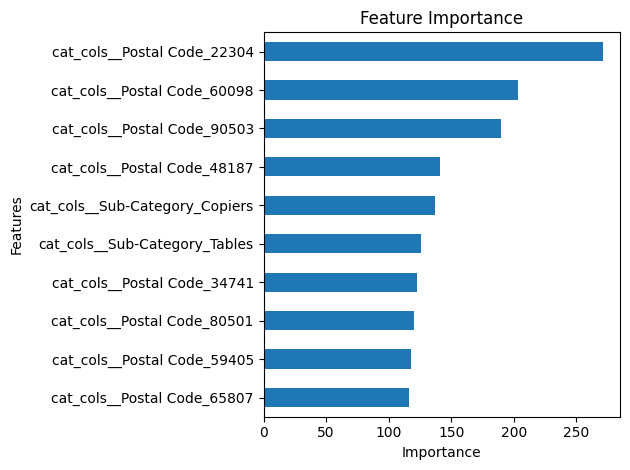

In [47]:
feature_names = transformer.get_feature_names_out()
feature_importances = model.named_steps['ridge'].coef_

feat_imf = pd.Series(feature_importances, index=feature_names).sort_values()

feat_imf.tail(10).plot(kind="barh")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.tight_layout()
plt.savefig("Feature Importance.png")

## Log the Ridge model we created with the feature importance graph as attachment



# Log Model With Vertex AI & Then Vectice
- capture model 
- capture experiment & run info 
- Vertex attachments ? Graphs etc

In [48]:
aiplatform.init(experiment="ridge-regression-001")

In [49]:
aiplatform.start_run("run-002")

Associating projects/599225543291/locations/us-central1/metadataStores/default/contexts/ridge-regression-001-run-002 to Experiment: ridge-regression-001


In [50]:
aiplatform.log_model(model)

2023-07-18 06:51:53.616136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 06:52:00.290978: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-18 06:52:00.292404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [51]:
aiplatform.log_metrics({"mae_train": round(mae_train,2), "mae_test": round(mae_test,2)})

In [52]:
parameters = {key: str(val) for key, val in model.named_steps.items()}

In [53]:
aiplatform.log_params(parameters)  #  We should prevent or flag object capture

In [54]:
aiplatform.end_run()

In [55]:
experiment = aiplatform.ExperimentRun("run-002", "ridge-regression-001") # We could pass the experiemtn to capture metrics, params and metadata

In [56]:
ridge_metrics = experiment.get_metrics()

In [57]:
ridge_params = experiment.get_params()

In [59]:
# Retrieve model artifact from vertex ai 
exp_model = aiplatform.get_experiment_model(artifact_id="592e6413-daf0-4a93-bd1c-0bf57d1f4816")

In [60]:
# Model metadata
exp_model.metadata

{'modelFile': 'model.pkl',
 'frameworkVersion': '1.0.2',
 'modelClass': 'sklearn.pipeline.Pipeline',
 'frameworkName': 'sklearn'}

In [61]:
# Retrieve the model from Vertex AI 
model = exp_model.load_model()

In [62]:
vect_model = vectice.Model(library="scikit-learn", 
                            technique="Ridge Regression",
                            metrics=ridge_metrics, 
                            properties=ridge_params, 
                            predictor=model,                        # Pass your model as a predictor to save it as a pickle file
                            derived_from=modeling_dataset,          # Pass your modeling dataset to document the lineage
                            attachments="Feature Importance.png")   # Pass your Feature Important graph as an attachment

### Assign the Ridge model to the step

You can add multiple models to a single step by using the `+=` operator.

In [63]:
model_iteration.step_build_model += vect_model

Model Pipeline successfully attached to Model(name='scikit-learn Ridge Regression model', version='Version 2').
Existing Model: 'scikit-learn Ridge Regression model' and Version: 'Version 2' already linked to Step: Build Model
Attachments: Feature Importance.png
Link to Step: https://app.vectice.com/browse/iteration/ITR-1246



# Log a Model With Vertex AI using autolog & Vectice

In [94]:
aiplatform.init(
    experiment="tutorial-ridge",
    project="tries-and-spikes",
    location="us-central1",
)

aiplatform.autolog()

# Your model training code goes here
OHE = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

cat_cols = ['Ship Mode', 'Segment', 'Country', 'City', 'State', 'Postal Code','Region', 'Category', 'Sub-Category']
num_cols = ['Quantity', 'Discount', 'Profit']

transformer = ColumnTransformer([('cat_cols', OHE, cat_cols),
                                ('num_cols', scaler, num_cols)])

model = make_pipeline(transformer,Ridge())
model.fit(X_train,y_train)

y_train_pred = model.predict(X_train)
mae_train=mean_absolute_error(y_train, y_train_pred)
y_test_pred = model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_test_pred)

# Insert Vectice to capture
vect_model = vectice.Model(library="scikit-learn", 
                            technique="Ridge Regression",
                            metrics={"mae_train": round(mae_train,2), "mae_test": round(mae_test,2)}, 
                            properties=model.named_steps, 
                            predictor=model,                        # Pass your model as a predictor to save it as a pickle file
                            derived_from=modeling_dataset,          # Pass your modeling dataset to document the lineage
                            attachments="Feature Importance.png")   # Pass your Feature Important graph as an attachment

aiplatform.autolog(disable=True)

2023/07/18 07:10:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023/07/18 07:10:16 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pyspark.ml. If you encounter errors during autologging, try upgrading / downgrading pyspark.ml to a supported version, or try upgrading MLflow.


Associating projects/599225543291/locations/us-central1/metadataStores/default/contexts/tutorial-ridge-sklearn-2023-07-18-07-10-16-0fae2 to Experiment: tutorial-ridge


INFO:google.cloud.aiplatform.metadata.experiment_resources:Associating projects/599225543291/locations/us-central1/metadataStores/default/contexts/tutorial-ridge-sklearn-2023-07-18-07-10-16-0fae2 to Experiment: tutorial-ridge
2023/07/18 07:10:17 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('columntransformer', ColumnTransformer(transformers=[('cat_cols',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Ship Mode', 'Segment', 'Country', 'City',
                                  'State', 'Postal Code', 'Region', 'Category',
                                  'Sub-Category']),
                                ('num_cols', StandardScaler(),
                                 ['Quantity', 'Discount', 'Profit'])])), ('ridge', R...`


In [95]:
# You can get the run and experiment from the logging output. Experiment name = `tutorial-ridge` & Run name = `sklearn-2023-06-29-09-55-07-3acb6`
# `Associating projects/599225543291/locations/us-central1/metadataStores/default/contexts/tutorial-ridge-sklearn-2023-06-29-09-55-07-3acb6 to Experiment: tutorial-ridge`
autolog_exp = aiplatform.ExperimentRun("sklearn-2023-07-18-07-10-16-0fae2", "tutorial-ridge")

In [90]:
autolog_artifacts = autolog_exp.get_artifacts()
autolog_artifacts

 resource name: projects/599225543291/locations/us-central1/metadataStores/default/artifacts/tutorial-ridge-sklearn-2023-06-29-09-55-07-3acb6-tb-run
 uri: https://us-central1-aiplatform.googleapis.com/v1/projects/599225543291/locations/us-central1/tensorboards/3324738444441157632/experiments/tutorial-ridge/runs/sklearn-2023-06-29-09-55-07-3acb6
 schema_title:google.VertexTensorboardRun]

In [98]:
autolog_model = aiplatform.get_experiment_model(artifact_id="tutorial-ridge-sklearn-2023-07-18-07-10-16-0fae2-tb-run")

In [103]:
autolog_metrics = autolog_exp.get_metrics()
autolog_params = autolog_exp.get_params()

In [ ]:
vect_model = vectice.Model(library="scikit-learn", 
                            technique="Ridge Regression",
                            metrics=autolog_metrics, 
                            properties=autolog_params, 
                            predictor=model,                        # Pass your model as a predictor to save it as a pickle file
                            derived_from=modeling_dataset,          # Pass your modeling dataset to document the lineage
                            attachments="Feature Importance.png")   # Pass your Feature Important graph as an attachment

## Add a comment 

Passing a `string` to a step will add a comment.

In [38]:
# Select the model to be staged
model_iteration.step_model_validation = f"Model passed acceptance criteria\nMAE Train: {round(mae_train,2)}\nMAE Test: {round(mae_test,2)}"

C:\Users\Aidan\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Added Comment to Step: Model Validation

Link to Step: https://app.vectice.com/browse/iteration/ITR-1167



In [39]:
model_iteration.complete()

C:\Users\Aidan\AppData\Local\Programs\Python\Python39\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Iteration with index 1 completed.

For quick access to the Iteration in the Vectice web app, visit:
https://app.vectice.com/browse/iteration/ITR-1167


## 🥇 Congrats! You learn how to succesfully use Vectice to auto-document the Modeling phase of the Tutorial Project.<br>
### Next we encourage you to explore other notebooks in the tutorial series. You can find those notebooks in Vectice public GitHub repository : https://github.com/vectice/GettingStarted/

✴ You can view your registered assets and comments in the UI by clicking the links in the output messages..